# 沪深300
数据为2024年10月11的收盘数据

In [1]:
import sqlite3
import math
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import time
from tqdm import tqdm

In [424]:
def fold_s(s, ncols:int = 8):
    if len(s) <= ncols:
        return pd.Series(s).to_frame().T
    s = pd.Series(s)
    nrows = math.ceil(len(s)/ncols)
    s = s.reindex(range(ncols * nrows), fill_value='')
    df = pd.DataFrame(s.values.reshape(nrows, ncols))
    return df

def save_to_db(df:pd.DataFrame, db:str, tb:str):
    conn = sqlite3.connect(db)
    df.to_sql(tb, conn, if_exists='append', index=False)
    conn.close()

def read_from_db(db: str, tb: str) -> pd.DataFrame:
    # 连接到 SQLite3 数据库
    conn = sqlite3.connect(db)
    # 从表中读取数据到 DataFrame
    df = pd.read_sql_query(f"SELECT * FROM {tb}", conn)
    # 关闭数据库连接
    conn.close()
    
    return df

def get_inc_df(df:pd.DataFrame):
    dft = df.pivot_table(index='日期', columns='股票代码', values='收盘')
    dft = dft.loc[dft.index > '2004-12-31']
    dft = dft.map(lambda x : x if x>0 else np.nan)
    dft = dft.ffill()
    inc = dft.map(np.log).diff()
    return inc

def get_price_df(df:pd.DataFrame):
    dft = df.pivot_table(index='日期', columns='股票代码', values='收盘')
    dft = dft.map(lambda x : x if x>0 else np.nan)
    dft = dft.ffill()
    dft = dft.loc[dft.index > '2004-12-31']
    price = np.log(dft)
    # 减去指数的变动。
    hs_hist_df = read_from_db('hist.db', 'idx_hist')
    hs_log = np.log(hs_hist_df.iloc[:,2]).to_frame('hs')
    hs_log.index = dft.index
    price = price.sub(hs_log.iloc[:,0], axis=0)
    def de_first(s:pd.Series):
        idx = s.first_valid_index()
        return s - s[idx]
    price = price.apply(de_first)
    return price

In [425]:
# 解决matplotlib的中文问题
# bash中使用fc-list 找到family name
# plt.rcdefaults() # 样式调乱了，需要用它重置一下。
font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
fm.fontManager.addfont(font_path)
# 设置全局字体为
matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.style.use('ggplot')

## 获得指数实时行情

In [426]:
# 获得指数实时行情
spot_em_df = ak.stock_zh_index_spot_em(symbol="上证系列指数")
spot_em_df.sort_values(by='成交额', ascending=False)[['代码','名称', '成交额']].head(20)

,代码,名称,成交额
69,000902,中证流通,9.514478e+11
67,000985,中证全指,9.433948e+11
95,000906,中证800,4.862159e+11
79,000001,上证指数,4.167595e+11
76,000002,Ａ股指数,4.162487e+11
78,000017,新综指,4.128445e+11
83,000090,上证流通,4.128445e+11
20,000967,基本600,3.711798e+11
99,000300,沪深300,3.221819e+11
123,000984,300等权,3.221819e+11


本来应该找全收益指数的，但试了几个地方都没有这个数据。全收益包括了分红进行再投资，所以收益率会比价格指数高。

## 获得指数成分

In [427]:
cons_df = ak.index_stock_cons(symbol="000300")
cons_df.groupby(cons_df['纳入日期'].str[:4]).count()

,品种代码,品种名称,纳入日期
纳入日期,,,
2005,34,34,34
2006,4,4,4
2007,13,13,13
2008,9,9,9
2009,5,5,5
2010,9,9,9
2011,9,9,9
2012,7,7,7
2013,9,9,9


- 这个数据有20个重复的项目。但只有它有纳入时间的选项。
- 2005年最开始纳入指数的300家，现在只剩下了34家了。
- 2018年以来，更换成分的速度明显加快。

In [428]:
# 应该使用这个接口
csindex_df = read_from_db('hist.db', 'cons')
# ['日期', '指数代码', '指数名称', '指数英文名称', '成分券代码', '成分券名称', '成分券英文名称', '交易所','交易所英文名称']
csindex_df = csindex_df[['日期', '成分券代码', '成分券名称',  '交易所']]
csindex_df['link'] = [f'<a href="https://data.eastmoney.com/stockdata/{x[2]}.html" target="_blank">{x[3]}</a>' for x in csindex_df.itertuples()]
code2link = csindex_df.set_index('成分券代码')['link']
name2link = csindex_df.set_index('成分券名称')['link']

## 获得指数历史行情

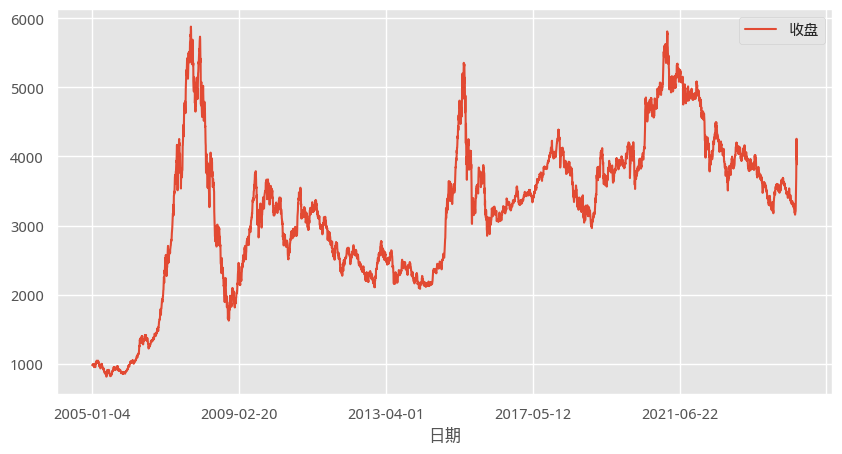

In [429]:
hs_hist_df = read_from_db('hist.db', 'idx_hist')
plt.show(hs_hist_df.iloc[:,[0,2]].plot(x='日期', figsize=(10,5)))

## 获取成分股历史行情

In [430]:
def get_hist(codes:list):
    df = pd.DataFrame()
    for code in tqdm(codes):
        hist_df = ak.stock_zh_a_hist(symbol=code, period="daily", adjust="hfq")
        df = pd.concat([df, hist_df], ignore_index=True)
        time.sleep(1)
    return df

In [431]:
df = read_from_db('hist.db', 'hs300')
dft = read_from_db('hist.db', 'pivot')

In [432]:
price_df = get_price_df(df)

In [433]:
inc_df = get_inc_df(df)

## 交易天数

In [434]:
days = inc_df.count().value_counts().to_frame('count')
days['years'] = days.index / 250
days.groupby(days['years'].apply(math.floor))['count'].sum().to_frame().T

years,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,2,10,11,16,13,12,13,3,18,6,2,17,15,17,7,19,12,2,105


- 超过三分之一的成份是2005年以前上市交易的。
- 近五年上市的成分股为38家。

## 总增长
近20年的总增长情况

In [435]:
total = inc_df.sum().sort_values(ascending=False)
display(f'总体正增长:{(total > 0).sum()}家')
total.describe().to_frame().T

'总体正增长:266家'

,count,mean,std,min,25%,50%,75%,max
0,300.0,1.586861,1.339897,-1.217562,0.487904,1.443721,2.609983,5.819524


- 近20年，总体正增长有266家，有34家没有实现增长。
- 平均增长1.57倍，每年增长约为8%
- 中位数低于平均值。

In [436]:
total.groupby(total.apply(lambda x: math.floor(x))).count().to_frame().T

,-2,-1,0,1,2,3,4,5
0,2,32,83,69,66,37,9,2


- 大部分公司的增长在2倍以内。
- 超过2倍的数量为114家。换算下来大约每年10%

In [437]:
display(f'from {total.max():.2f} to {total.min():.2f}')
fold_s([code2link[x] for x in total.index], 8).style

'from 5.82 to -1.22'

,0,1,2,3,4,5,6,7
0,藏格矿业,贵州茅台,格力电器,山西汾酒,恒瑞医药,泸州老窖,片仔癀,长春高新
1,中航沈飞,恒生电子,古井贡酒,闻泰科技,三一重工,伊利股份,五 粮 液,中际旭创
2,新和成,华东医药,北方稀土,上海医药,北新建材,国电南瑞,海尔智家,紫光国微
3,山东黄金,万华化学,立讯精密,云南白药,中航西飞,航发动力,北方华创,华兰生物
4,东方财富,通威股份,中科曙光,川投能源,阳光电源,三花智控,特变电工,东方雨虹
5,浪潮信息,中国巨石,恒力石化,宝信软件,牧原股份,同花顺,四川路桥,福耀玻璃
6,招商银行,中金黄金,科大讯飞,中信证券,亿纬锂能,重庆啤酒,大华股份,徐工机械
7,爱尔眼科,万泰生物,华润三九,复星医药,隆基绿能,广发证券,歌尔股份,华域汽车
8,泰格医药,圣邦股份,天坛生物,华鲁恒升,韦尔股份,中联重科,海螺水泥,汇川技术
9,双汇发展,兆易创新,长电科技,新 希 望,小商品城,长安汽车,万科A,中航光电


## 平均增长

In [438]:
(inc_df.mean()*250).describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,300.0,0.117699,0.114726,-0.305162,0.045544,0.115362,0.179005,0.655157


日均增长简单乘250得到年化增长。中位数、平均数为11.5%左右。

In [439]:
mean_s = (inc_df.mean()*250).sort_values(ascending=0)
display(f'from {mean_s.max():.2f} to {mean_s.min():.2f}')
fold_s([code2link[x] for x in mean_s.index]).style

'from 0.66 to -0.31'

,0,1,2,3,4,5,6,7
0,万泰生物,德业股份,东鹏饮料,卓胜微,宁德时代,圣邦股份,韦尔股份,中国海油
1,福莱特,海光信息,中科曙光,兆易创新,康龙化成,中际旭创,迈为股份,藏格矿业
2,牧原股份,深南电路,新产业,中国卫通,中国移动,先导智能,贵州茅台,立讯精密
3,阳光电源,迈瑞医疗,华友钴业,亿联网络,格力电器,山西汾酒,恒瑞医药,天赐材料
4,北方华创,泸州老窖,东方财富,片仔癀,长春高新,泰格医药,隆基绿能,药明康德
5,中科创达,中航沈飞,中信建投,恒生电子,同花顺,凯莱英,德赛西威,古井贡酒
6,闻泰科技,东方雨虹,三一重工,伊利股份,亿纬锂能,五 粮 液,华能水电,传音控股
7,新和成,美的集团,爱尔眼科,华东医药,汇川技术,紫光国微,北方稀土,上海医药
8,比亚迪,北新建材,拓普集团,国电南瑞,海尔智家,陕西煤业,山东黄金,万华化学
9,科大讯飞,云南白药,大华股份,中航西飞,晶盛机电,航发动力,歌尔股份,华兰生物


## 增长质量

In [440]:
def get_slope(s:pd.Series):
    y = s.dropna().values  # y 值为序列的值
    x = np.arange(len(y))  # x 值为序列的索引
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    # 计算残差
    y_pred = slope * x + intercept
    residuals = y - y_pred
    # 计算残差的标准差（Residual Standard Error）
    residual_std_dev = np.std(residuals)
    ret = slope / (residual_std_dev + 1e-10)  # 避免除以零
    return ret

In [441]:
sharpee = price_df.mean() / price_df.std()
sharpee = sharpee.sort_values(ascending=False)
sharpee.index = [code2link[x] for x in sharpee.index]

In [442]:
fold_s(sharpee.index).style

,0,1,2,3,4,5,6,7
0,三峡能源,万泰生物,卓胜微,中科曙光,春秋航空,东鹏饮料,先导智能,中国卫通
1,兆易创新,深南电路,公牛集团,药明康德,视源股份,康龙化成,福莱特,中科创达
2,德业股份,迈瑞医疗,爱美客,华友钴业,中航西飞,中信建投,洋河股份,凯莱英
3,亿联网络,信达证券,中信证券,蓝思科技,沪硅产业,晨光股份,韦尔股份,芒果超媒
4,华大九天,新产业,深信服,璞泰来,保利发展,歌尔股份,大华股份,宁德时代
5,三一重工,科大讯飞,昆仑万维,金山办公,藏格矿业,红塔证券,中金公司,泸州老窖
6,欧派家居,万科A,云南白药,山东黄金,中金黄金,三环集团,浦发银行,东方雨虹
7,中联重科,圣邦股份,中国核电,广联达,华兰生物,新 希 望,泰格医药,恩捷股份
8,建设银行,中国移动,双汇发展,长城汽车,格力电器,美的集团,上海莱士,海螺水泥
9,合盛硅业,迈为股份,中国船舶,贵州茅台,航发动力,中国巨石,北方稀土,立讯精密


In [443]:
slope = price_df.apply(get_slope).sort_values(ascending=False)
slope.index = [code2link[x] for x in slope.index]
fold_s(slope.index).style

,0,1,2,3,4,5,6,7
0,中国海油,中国移动,中国电信,海光信息,东鹏饮料,宝丰能源,中国能建,今世缘
1,德赛西威,华能水电,中航光电,宁德时代,立讯精密,星宇股份,牧原股份,海大集团
2,邮储银行,迈瑞医疗,隆基绿能,爱尔眼科,圣邦股份,贵州茅台,美的集团,迈为股份
3,海尔智家,成都银行,汇川技术,恒瑞医药,亿联网络,三环集团,传音控股,亿纬锂能
4,晶盛机电,北方华创,恒立液压,北新建材,赣锋锂业,福莱特,东方雨虹,海康威视
5,泰格医药,中际旭创,片仔癀,宁波银行,德业股份,南京银行,公牛集团,中国中免
6,智飞生物,东方财富,格力电器,陕西煤业,韦尔股份,海天味业,三花智控,盛美上海
7,科大讯飞,福耀玻璃,中航沈飞,古井贡酒,拓普集团,晨光股份,恒生电子,恒力石化
8,天赐材料,长春高新,兆易创新,中国广核,华东医药,福斯特,同花顺,阳光电源
9,先导智能,凯莱英,寒武纪,招商银行,中国巨石,伊利股份,兴业银行,杭州银行


In [444]:
display('前50重叠')
fold_s(list(set(slope.index[:50]) & set(sharpee.index[:50]))).style

'前50重叠'

,0,1,2,3,4,5,6
0,亿联网络,迈瑞医疗,东鹏饮料,公牛集团,福莱特,德业股份,宁德时代


In [445]:
display('后50重叠')
fold_s(list(set(slope.index[-50:]) & set(sharpee.index[-50:]))).style

'后50重叠'

,0,1,2,3,4,5,6,7
0,中煤能源,中国东航,中国中冶,大秦铁路,中国铝业,中国石化,中国联通,中远海能
1,中海油服,华利集团,招商蛇口,光大证券,申万宏源,澜起科技,华能国际,温氏股份
2,联影医疗,国泰君安,浙能电力,宝钢股份,上海银行,中油资本,中国石油,京东方A


两指标排名前50几乎没有重叠的。后50重叠的也只有24个。

In [449]:
import nbformat as nbf
from pathlib import Path
def remove_input():
    fn = Path('hs300.ipynb')
    nb = nbf.read(fn, nbf.NO_CONVERT)
    for cell in nb.cells:
        cell_tags = cell.get('metadata', {}).get('tags', [])
        if not 'remove_input' in cell_tags:
            cell_tags.append('remove_input')
            cell['metadata']['tags'] = cell_tags
    nbf.write(nb, fn)
remove_input()